In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#sklearn imports
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [3]:
#Function declaration
def analyze(df):
    print(df.info(), df.describe())
    
def feature_impotances(X, y, model=RandomForestClassifier(random_state=42)):
    model.fit(X, y)
    imp_dict = {}
    for col, score in zip(X.columns, model.feature_importances_):
        imp_dict[col] = score.round(4)
    print(imp_dict)
    print("Unimportant features: ", "\n")
    print([col for col in imp_dict if imp_dict[col] == 0])
    
def score_model(X_train, y_train, X_valid, y_valid, model):
    model.fit(X_train, y_train)
    y_predt = model.predict(X_train)
    y_predv = model.predict(X_valid)
    print("train accuracy:", accuracy_score(y_train, y_predt), precision_score(y_train, y_predt), recall_score(y_train, y_predt))
    print("valid accuracy:", accuracy_score(y_valid, y_predv), precision_score(y_valid, y_predv), recall_score(y_valid, y_predv))
    print("")
    
def tune_hyperparameter(X_train, y_train, X_valid, y_valid, gridsearch):
    score_model(X_train, y_train, X_valid, y_valid, gridsearch)
    print(gridsearch.best_params_, "\n")
    
def prepare_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices((X, y)).batch(32).prefetch(1)

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["train", "valid"])

In [4]:
#Prepare datasets
X = pd.read_csv('/kaggle/input/titanic/train.csv')
X.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
y = X.pop('Survived')
X_test = pd.read_csv('/kaggle/input/titanic/test.csv')
X_test.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

num_cols = X.select_dtypes(['number']).columns
cat_cols = X.select_dtypes(['object']).columns

to_drop = X[X['Embarked'].isnull()].index
X.drop(to_drop, inplace=True)
y.drop(to_drop, inplace=True)

print(num_cols, "\n", cat_cols)
print(y.value_counts())
print(X.shape, y.shape)
analyze(X)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object') 
 Index(['Sex', 'Cabin', 'Embarked'], dtype='object')
Survived
0    549
1    340
Name: count, dtype: int64
(889, 8) (889,)
<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    object 
 2   Age       712 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   Cabin     202 non-null    object 
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 62.5+ KB
None            Pclass         Age       SibSp       Parch        Fare
count  889.000000  712.000000  889.000000  889.000000  889.000000
mean     2.311586   29.642093    0.524184    0.382452   32.096681
std      0.834700   14.492933    1.103705    0.806761  

In [5]:
#Feature engineering
def feature_engineer(df):
    df = df.copy()
    #df['Ticket'] = df['Ticket'].apply(lambda x: x[:3] if len(x) > 7 else 'normal')
    df['Cabin'] = df['Cabin'].apply(lambda x: 1 if type(x) == str else 0)
    return df
X_eng = feature_engineer(X)

#plt.hist(X_eng.Age)
print(X_eng.Cabin.unique())

num_cols = X_eng.select_dtypes(['number']).columns
cat_cols = X_eng.select_dtypes(['object']).columns
print(num_cols, "\n", cat_cols)
analyze(X_eng)

[0 1]
Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin'], dtype='object') 
 Index(['Sex', 'Embarked'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    object 
 2   Age       712 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   Cabin     889 non-null    int64  
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB
None            Pclass         Age       SibSp       Parch        Fare       Cabin
count  889.000000  712.000000  889.000000  889.000000  889.000000  889.000000
mean     2.311586   29.642093    0.524184    0.382452   32.096681    0.227222
std      0.834700   14.492933    1.103705    0.806761   49.697504    0.419273
min 

In [6]:
#Data preprocessing
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'), 
    #PCA(0.95, random_state=42), 
    StandardScaler()
)
cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)
col_transformer = make_column_transformer(
    (num_pipeline, num_cols), 
    (cat_pipeline, cat_cols)
)

col_transformer.fit(X_eng)
X_trans = pd.DataFrame(col_transformer.transform(X_eng), columns=col_transformer.get_feature_names_out(), index=X_eng.index)
print(X_trans.shape, y.shape)
analyze(X_trans)

(889, 11) (889,)
<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pipeline-1__Pclass      889 non-null    float64
 1   pipeline-1__Age         889 non-null    float64
 2   pipeline-1__SibSp       889 non-null    float64
 3   pipeline-1__Parch       889 non-null    float64
 4   pipeline-1__Fare        889 non-null    float64
 5   pipeline-1__Cabin       889 non-null    float64
 6   pipeline-2__Sex_female  889 non-null    float64
 7   pipeline-2__Sex_male    889 non-null    float64
 8   pipeline-2__Embarked_C  889 non-null    float64
 9   pipeline-2__Embarked_Q  889 non-null    float64
 10  pipeline-2__Embarked_S  889 non-null    float64
dtypes: float64(11)
memory usage: 83.3 KB
None        pipeline-1__Pclass  pipeline-1__Age  pipeline-1__SibSp  \
count        8.890000e+02     8.890000e+02       8.890000e+02   
mean        -2.43

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
#feature_impotances(X_trans, y)

In [8]:
#Train & Test set preparation
X_train, X_valid, y_train, y_valid = train_test_split(X_trans, y, stratify=y, random_state=42)

print(y_train.value_counts(), y_valid.value_counts())
print(X_train.shape, y_train.shape)

Survived
0    411
1    255
Name: count, dtype: int64 Survived
0    138
1     85
Name: count, dtype: int64
(666, 11) (666,)


In [9]:
#Model training & selection
lr = LogisticRegression(random_state=42, max_iter=1000, tol=1e-3)
svc = SVC(random_state=42)
# rfc = RandomForestClassifier(random_state=42)
etc = ExtraTreesClassifier(random_state=42)
abc = AdaBoostClassifier(random_state=42)
# knc = KNeighborsClassifier()

score_model(X_train, y_train, X_valid, y_valid, lr)
score_model(X_train, y_train, X_valid, y_valid, svc)
# score_model(X_train, y_train, X_valid, y_valid, rfc)
score_model(X_train, y_train, X_valid, y_valid, etc)
score_model(X_train, y_train, X_valid, y_valid, abc)
# score_model(X_train, y_train, X_valid, y_valid, knc)

train accuracy: 0.8063063063063063 0.7540322580645161 0.7333333333333333
valid accuracy: 0.7847533632286996 0.7126436781609196 0.7294117647058823

train accuracy: 0.8393393393393394 0.827433628318584 0.7333333333333333
valid accuracy: 0.8116591928251121 0.7866666666666666 0.6941176470588235

train accuracy: 0.984984984984985 0.9919678714859438 0.9686274509803922
valid accuracy: 0.7937219730941704 0.7191011235955056 0.7529411764705882

train accuracy: 0.8498498498498499 0.8297872340425532 0.7647058823529411
valid accuracy: 0.7982062780269058 0.7222222222222222 0.7647058823529411



In [10]:
#Hyperparameter tuning
param_grid1 = {'C': [0.1, 1.0, 10]}
param_grid2 = {'C': [0.1, 1.0, 10, 100], 'degree': [1, 2, 3], 'kernel': ["rbf", "poly"]}
# param_grid3 = {'max_depth': [5, 10, 50, 100], 'min_samples_split': [4, 6, 8, 10], 'n_estimators': [50, 100, 500]}
param_grid3 = {'n_estimators': range(100, 1001), 'min_samples_split': range(2, 10), 'max_depth': range(1, 15)}
param_grid4 = {'learning_rate': [0.1, 1.0, 10], 'n_estimators': [10, 50, 100, 500]}
# param_grid5 = {'n_neighbors': range(2, 11)}

gs_lr = GridSearchCV(lr, param_grid1, cv=3)
gs_svc = GridSearchCV(svc, param_grid2, cv=3)
# gs_etc = GridSearchCV(etc, param_grid3, cv=5)
rs_etc = RandomizedSearchCV(etc, param_grid3, n_iter=15, cv=5, random_state=42)
gs_abc = GridSearchCV(abc, param_grid4, cv=3)

tune_hyperparameter(X_train, y_train, X_valid, y_valid, gs_lr)
tune_hyperparameter(X_train, y_train, X_valid, y_valid, gs_svc)
tune_hyperparameter(X_train, y_train, X_valid, y_valid, rs_etc)
tune_hyperparameter(X_train, y_train, X_valid, y_valid, gs_abc)

train accuracy: 0.8063063063063063 0.7540322580645161 0.7333333333333333
valid accuracy: 0.7847533632286996 0.7126436781609196 0.7294117647058823

{'C': 1.0} 

train accuracy: 0.8393393393393394 0.827433628318584 0.7333333333333333
valid accuracy: 0.8161434977578476 0.782051282051282 0.7176470588235294

{'C': 1.0, 'degree': 2, 'kernel': 'poly'} 

train accuracy: 0.9564564564564565 0.9829059829059829 0.9019607843137255
valid accuracy: 0.7937219730941704 0.7349397590361446 0.7176470588235294

{'n_estimators': 201, 'min_samples_split': 3, 'max_depth': 13} 

train accuracy: 0.8378378378378378 0.8049792531120332 0.7607843137254902
valid accuracy: 0.7757847533632287 0.6881720430107527 0.7529411764705882

{'learning_rate': 0.1, 'n_estimators': 500} 



In [11]:
#Ensemble training & selection
lr.set_params(**gs_lr.best_params_)
svc.set_params(**gs_svc.best_params_)
svc.probability = True
svc.fit(X_train, y_train)
etc.set_params(**rs_etc.best_params_)
etc.min_samples_leaf = 5
# score_model(X_train, y_train, X_valid, y_valid, etc)
abc.set_params(**gs_abc.best_params_)

vc = VotingClassifier([
#     ('lr', lr), 
    ('svc', svc), 
#     ('etc', etc),
    ('abc', abc), 
#     ('knc', knc), 
], voting='soft')
sc = StackingClassifier([
#     ('lr', lr), 
    ('svc', svc), 
#     ('etc', etc),
    ('abc', abc), 
#     ('knc', knc), 
], cv=5)
score_model(X_train, y_train, X_valid, y_valid, vc)
score_model(X_train, y_train, X_valid, y_valid, sc)

train accuracy: 0.8378378378378378 0.8266666666666667 0.7294117647058823
valid accuracy: 0.8161434977578476 0.782051282051282 0.7176470588235294

train accuracy: 0.8378378378378378 0.8266666666666667 0.7294117647058823
valid accuracy: 0.8161434977578476 0.782051282051282 0.7176470588235294



In [12]:
#Final prediction
vc.fit(X_trans, y)
sc.fit(X_trans, y)
svc.fit(X_trans, y)
print(vc.score(X_valid, y_valid), sc.score(X_valid, y_valid), svc.score(X_valid, y_valid))

X_test_eng = feature_engineer(X_test)
# print(num_cols, "\n", cat_cols)
# analyze(X_test_eng)

X_test_trans = pd.DataFrame(col_transformer.transform(X_test_eng), columns=col_transformer.get_feature_names_out(), index=X_test_eng.index)
# print(X_test_trans.shape)
# analyze(X_test_trans)

predictions = pd.DataFrame({"PassengerId": X_test_trans.index+892, "Survived": svc.predict(X_test_trans)})
predictions.to_csv("submission.csv", index=False)
pd.read_csv('/kaggle/working/submission.csv')

0.8161434977578476 0.8161434977578476 0.8161434977578476


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [13]:
#Prepare tf dataset
train_set = prepare_dataset(X_train, y_train)
valid_set = prepare_dataset(X_valid, y_valid)

# for batch in train_set.take(1):
#     print(batch)

In [14]:
#Build model
from functools import partial

dense = partial(tf.keras.layers.Dense, kernel_initializer='lecun_normal', activation='selu')

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(), 
    dense(256), 
    dense(128), 
#     dense(64), 
    tf.keras.layers.Dropout(0.1), 
    dense(1, activation='sigmoid')
])

model.build([None, X_train.shape[1]])
model.summary()

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 11)               44        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               3072      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,141
Trainable params: 36,119
Non-trainable params: 22
___________________________________________________

Epoch 1/100
21/21 [==============================] - 4s 14ms/step - loss: 0.5095 - accuracy: 0.7688 - val_loss: 0.5156 - val_accuracy: 0.7713
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 0.4616 - accuracy: 0.8003 - val_loss: 0.4884 - val_accuracy: 0.7892
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 0.4392 - accuracy: 0.8168 - val_loss: 0.4720 - val_accuracy: 0.8027
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 0.4184 - accuracy: 0.8348 - val_loss: 0.4633 - val_accuracy: 0.8206
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 0.4146 - accuracy: 0.8378 - val_loss: 0.4601 - val_accuracy: 0.8206
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 0.4120 - accuracy: 0.8318 - val_loss: 0.4555 - val_accuracy: 0.8341
Epoch 7/100
21/21 [==============================] - 0s 5ms/step - loss: 0.4029 - accuracy: 0.8318 - val_loss: 0.4514 - val_accuracy: 0.8251
Epoch 8/100


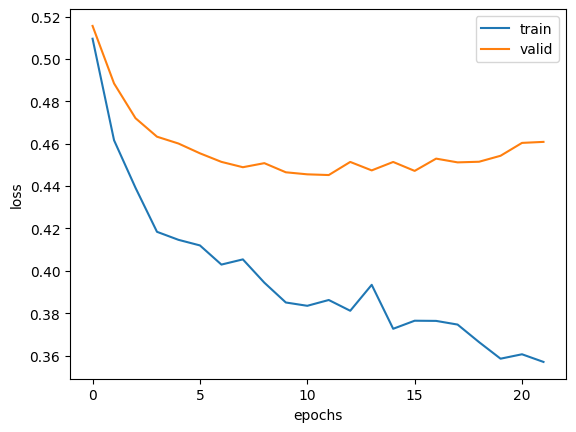

In [15]:
#Fit/Evaluate model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(train_set, validation_data=valid_set, epochs=100, callbacks=[early_stopping])

plot_loss(history)
#0.850  0.825

In [16]:
model.fit(train_set.concatenate(valid_set), epochs=1)
#0.821

28/28 [==============================] - 0s 4ms/step - loss: 0.4066 - accuracy: 0.8279


In [17]:
#Make predictions
X_test_eng = feature_engineer(X_test)
X_test_trans = pd.DataFrame(col_transformer.transform(X_test_eng), columns=col_transformer.get_feature_names_out(), index=X_test_eng.index)
# analyze(X_test_trans)

predictions = model.predict(tf.data.Dataset.from_tensor_slices(X_test_trans).batch(32).prefetch(1))
predictions = map(lambda x: 1 if x > 0.5 else 0, predictions)

sample = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
submission2 = pd.DataFrame({"PassengerId": sample.PassengerId, "Survived": predictions})
submission2.to_csv('submission2.csv', index=False)
pd.read_csv('/kaggle/working/submission2.csv')

14/14 [==============================] - 0s 2ms/step


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
